# PRE - PROCESSING

## Import functions

In [1]:
#pip install xgboost==2.1.1

In [2]:
#pip install pandas==2.1.4

In [3]:
#pip install meteostat

In [4]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import joblib

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [6]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [7]:
data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [8]:
data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


In [9]:
data_till_2019.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [10]:
data_till_2019.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122708,11442.870,2019-12-31,20,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122709,11166.770,2019-12-31,21,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122710,10838.550,2019-12-31,22,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122711,10592.674,2019-12-31,23,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122712,10364.707,2020-01-01,0,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [11]:
case_study_data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122713,10291.858,2020-01-01,1,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122714,10252.082,2020-01-01,2,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122715,10303.804,2020-01-01,3,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122716,10588.920,2020-01-01,4,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122717,10980.540,2020-01-01,5,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [12]:
case_study_data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


# old MODEL BUILDING

## Prediction with date time features (entire data)

In [13]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

Xgb_dt_reg = xgb.XGBRegressor()
Xgb_dt_reg.fit(X_train, y_train)
predictions = Xgb_dt_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {Xgb_dt_reg.score(X_test, y_test)}")

RMSE: 2334.5866202698194
MAE: 1810.4482375195005
MAPE: 0.14608481841342663
R^2: 0.16985205195983843


## Prediction with weather features and datetime (entire data)

In [14]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

Xgb_all_reg = xgb.XGBRegressor()
Xgb_all_reg.fit(X_train, y_train)
predictions = Xgb_all_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {Xgb_all_reg.score(X_test, y_test)}")

RMSE: 1601.693345940553
MAE: 1241.9353336744211
MAPE: 0.09950394625398733
R^2: 0.6092542554187387


In [15]:
import xgboost as xgb
import pandas as pd
print(f"xgboost version: {xgb.__version__}")
print(f"pandas version: {pd.__version__}")

xgboost version: 2.1.1
pandas version: 2.1.4


## Prediction with date time features (2006 - 2019)

In [16]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

Xgb_dt2019_reg = xgb.XGBRegressor()
Xgb_dt2019_reg.fit(X_train, y_train)
predictions = Xgb_dt2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {Xgb_dt2019_reg.score(X_test, y_test)}")

RMSE: 2030.1985115807056
MAE: 1484.8650107293759
MAPE: 0.12870315583796685
R^2: 0.31083997464438695


## Prediction with weather features and datetime (2006 - 2019)

In [17]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

Xgb_all2019_reg = xgb.XGBRegressor()
Xgb_all2019_reg.fit(X_train, y_train)
predictions = Xgb_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {Xgb_all2019_reg.score(X_test, y_test)}")

RMSE: 755.538033767601
MAE: 593.4948986772401
MAPE: 0.05180710164451983
R^2: 0.9045544397747183


##Feature Importances

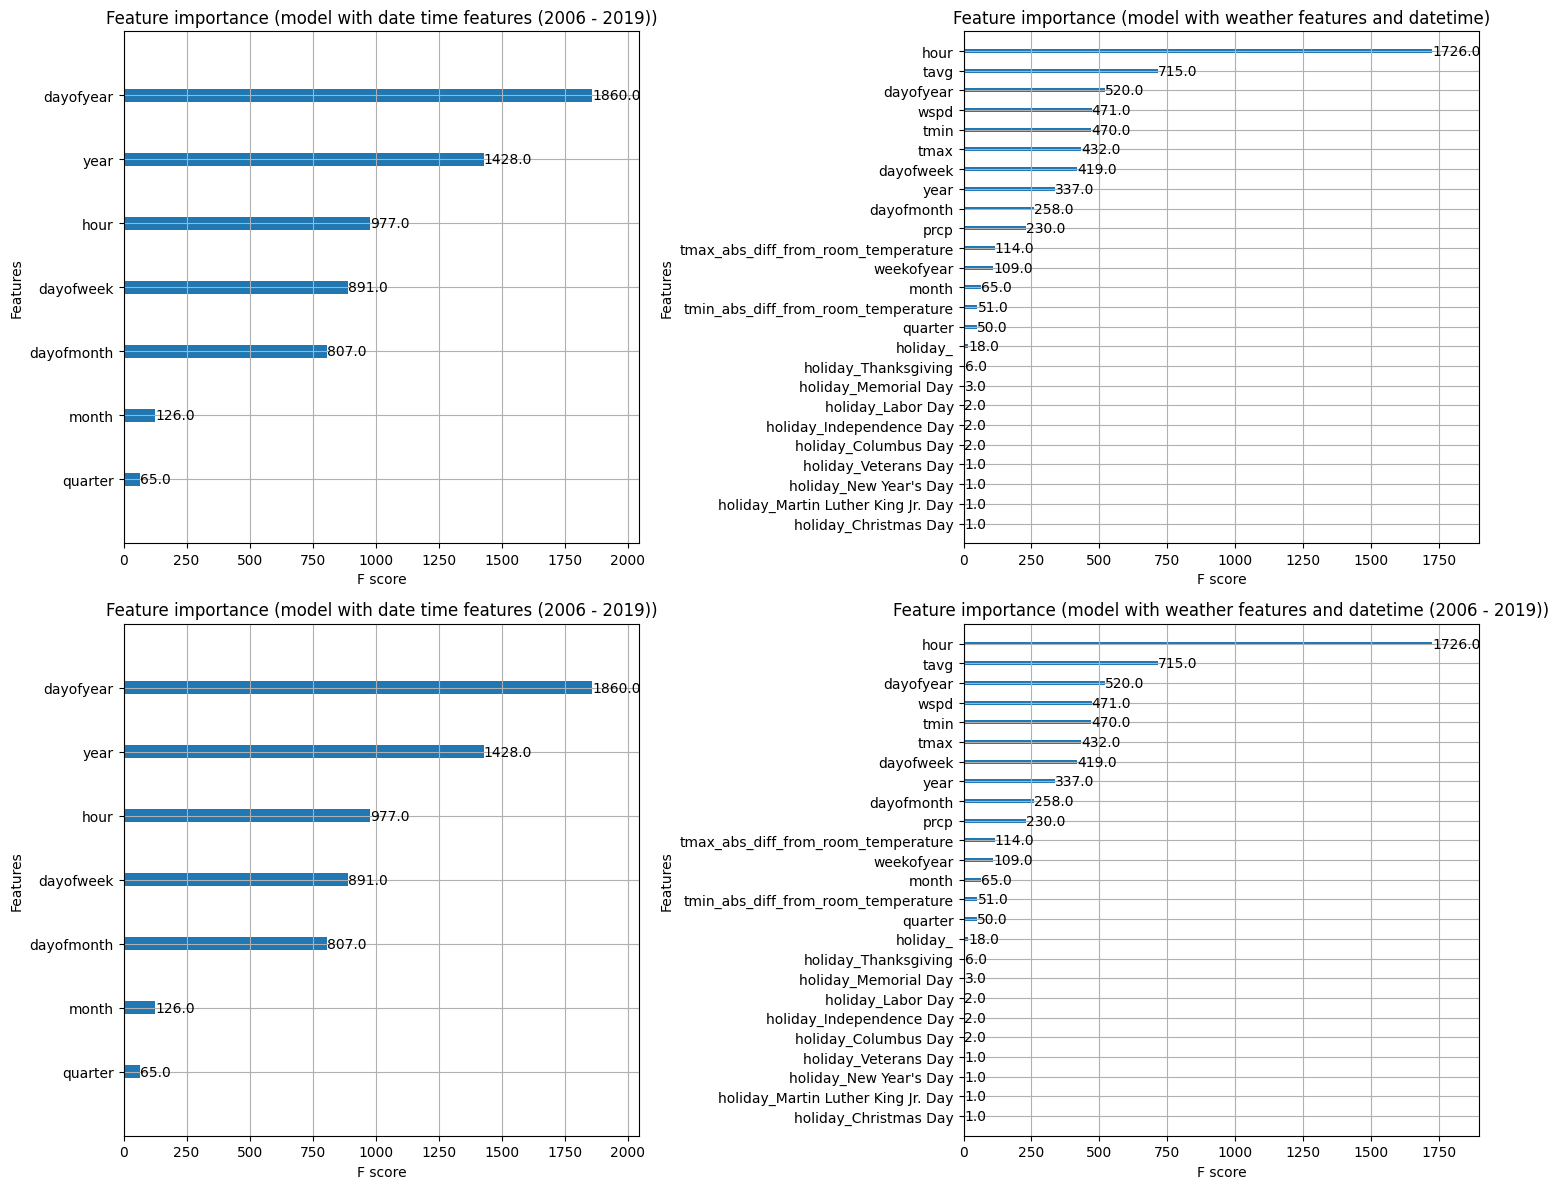

In [18]:
# Create a figure and set up 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot feature importance for each model
xgb.plot_importance(Xgb_dt_reg, ax=axes[0, 0], title='Feature importance (model with date time features (2006 - 2019))')
xgb.plot_importance(Xgb_all_reg, ax=axes[0, 1], title='Feature importance (model with weather features and datetime)')
xgb.plot_importance(Xgb_dt2019_reg, ax=axes[1, 0], title='Feature importance (model with date time features (2006 - 2019))')
xgb.plot_importance(Xgb_all2019_reg, ax=axes[1, 1], title='Feature importance (model with weather features and datetime (2006 - 2019))')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Retrain Model on case study

In [19]:
# Assuming Xgb_all2019_reg is already created and trained previously

# Splitting the data: training on 2020-2023, testing on 2024
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()  # Data from 2020 to end of 2023
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()  # Data from 2024

# Dropping unnecessary columns for training and testing
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']  # Adjust 'date' column if necessary
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Retraining the existing Xgb_all2019_reg on the new data (2020-2023)
Xgb_all2019_reg.fit(X_train, y_train)

# Predictions on 2024 data
predictions = Xgb_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100
r2 = Xgb_all2019_reg.score(X_test, y_test) * 100

# Print metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

RMSE: 887.888575185317
MAE: 693.3989447532929
MAPE: 4.77%
R^2: 87.25%


## Hyper parameter tunning

In [20]:
from sklearn.model_selection import GridSearchCV

# Splitting the data as you did previously
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define a small grid of hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100],         # Lower number of trees to reduce computation time
    'max_depth': [3, 5],               # Try smaller depths to keep the model simple
    'learning_rate': [0.05, 0.1],      # A couple of common learning rates
    'subsample': [0.8],                # Fixed subsample to reduce variance
    'colsample_bytree': [0.8],         # Reduce features used per tree to avoid overfitting
    'gamma': [0, 1]                    # Include some regularization
}

# Initialize the XGBoost regressor
Xgb_all2019_reg = xgb.XGBRegressor()

# Set up the GridSearchCV
xgb_grid_search = GridSearchCV(estimator=Xgb_all2019_reg,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation to reduce computation
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

# Fit grid search
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator to make predictions
xgb_best_model = xgb_grid_search.best_estimator_
predictions = xgb_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = xgb_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.2f}%")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
RMSE: 752.9111893520093
MAE: 589.6582594567033
MAPE: 5.13%
R^2: 90.52%


In [21]:
from sklearn.model_selection import GridSearchCV

# Splitting the data as you did previously
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define a finer grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200],       # Increased number of estimators for better learning
    'max_depth': [3, 5, 7],                # Deeper trees might capture more complex interactions
    'learning_rate': [0.01, 0.05, 0.1],    # Fine-tune learning rate
    'subsample': [0.8, 1.0],               # Test with full and subsampled data
    'colsample_bytree': [0.8, 1.0],        # Try using different fractions of features
    'gamma': [0, 0.5, 1],                  # Add regularization
    'reg_lambda': [1, 1.5],                # L2 regularization term
    'reg_alpha': [0, 0.5]                  # L1 regularization term
}

# Initialize the XGBoost regressor
Xgb_all2019_reg = xgb.XGBRegressor()

# Set up the GridSearchCV
xgb_grid_search = GridSearchCV(estimator=Xgb_all2019_reg,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation to reduce computation
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

# Fit grid search
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator to make predictions
xgb_best_model = xgb_grid_search.best_estimator_
predictions = xgb_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = xgb_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.2f}%")


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0}
RMSE: 709.9791362023335
MAE: 557.8291873717748
MAPE: 4.84%
R^2: 91.57%


In [23]:
# Save the best model to a file
joblib.dump(xgb_best_model, 'best_extreme_gradient_boosting_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [26]:
# Load the saved model
xgb_loaded_model = joblib.load('best_extreme_gradient_boosting_model.pkl')

# Use the loaded model for predictions
xgb_loaded_predictions = xgb_loaded_model.predict(X_test)

# Evaluate the loaded model
loaded_rmse = mean_squared_error(y_test, xgb_loaded_predictions, squared=False)
loaded_mae = mean_absolute_error(y_test, xgb_loaded_predictions)
loaded_mape = mean_absolute_percentage_error(y_test, xgb_loaded_predictions) * 100  # Convert to percentage
loaded_r2 = xgb_loaded_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

print(f"Loaded Model RMSE: {loaded_rmse}")
print(f"Loaded Model MAE: {loaded_mae}")
print(f"Loaded Model MAPE: {loaded_mape:.2f}%")
print(f"Loaded Model R^2: {loaded_r2:.2f}%")

Loaded Model RMSE: 709.9791362023335
Loaded Model MAE: 557.8291873717748
Loaded Model MAPE: 4.84%
Loaded Model R^2: 91.57%


# Model Building

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the XGBoost Regressor model
xgb_all2019_reg = XGBRegressor(random_state=22)
xgb_all2019_reg.fit(X_train_scaled, y_train)

# Predictions
predictions = xgb_all2019_reg.predict(X_test_scaled)

# Step 3: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {xgb_all2019_reg.score(X_test_scaled, y_test) * 100:.2f}")

# Step 4: Save the trained model
dump(xgb_all2019_reg, 'saved models/XGB/xgb_all2019_reg_model.joblib')

# Step 5: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'xgb_2019_Predicted']  # Rename columns for clarity
result_df.to_csv('saved models/XGB/xgb_all2019_reg_model_predictions_vs_actuals.csv')



Model Evaluation
RMSE: 755.538033767601
MAE: 593.4948986772401
MAPE: 5.18%
R^2: 90.46


In [14]:
# Case Study Example
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Load the previously saved model
loaded_model = load('saved models/XGB/xgb_all2019_reg_model.joblib')

# Step 2: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 4: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 5: Save the retrained model
dump(loaded_model, 'saved models/XGB/xgb_all2020_2023_retrained_model.joblib')

# Step 6: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'xgb_2023_Predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/XGB/xgb_all2020_2023_retrained_model_case_study_predictions_vs_actuals.csv')

Evaluation for case study July 2023 to July 2024
RMSE: 887.888575185317
MAE: 693.3989447532929
MAPE: 4.77%
R^2: 87.25%


# HYPER PARAMETER TUNNING

## HP1

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define the hyperparameter grid for XGBRegressor
param_grid = {
    'n_estimators': [50, 100],         # Number of trees in the ensemble
    'max_depth': [3, 5],               # Maximum depth of the tree
    'learning_rate': [0.05, 0.1],      # Step size shrinkage to make updates smaller
    'subsample': [0.8],                # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.8],         # Fraction of features used per tree
    'gamma': [0, 1]                    # Regularization to reduce overfitting
}

# Initialize the XGBoost Regressor
xgb_all2019_reg = XGBRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_all2019_reg,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               scoring='neg_mean_squared_error',  # Scoring based on negative MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit grid search to the training data
xgb_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
xgb_best_model = xgb_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = xgb_best_model.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {xgb_best_model.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(xgb_best_model, 'saved models/XGB/xgb_best_model_grid_search.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'xgb_grid_search_predicted']  # Rename columns for clarity
result_df.to_csv('saved models/XGB/xgb_grid_search_predictions_vs_actuals.csv')



Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' 

Model Evaluation
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
RMSE: 750.4152672613665
MAE: 587.0260934521071
MAPE: 5.11%
R^2: 90.58


In [14]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/XGB/xgb_best_model_grid_search.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/XGB/xgb_2020_2023_retrained_grid_search_model.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'xgb_grid_search_2023_predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/XGB/xgb_grid_search_2023_predictions_vs_actuals.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 949.5558926186583
MAE: 736.9896095504696
MAPE: 5.05%
R^2: 85.42%


## HP2

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a finer grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200],       # Increased number of estimators for better learning
    'max_depth': [3, 5, 7],                # Deeper trees might capture more complex interactions
    'learning_rate': [0.01, 0.05, 0.1],    # Fine-tune learning rate
    'subsample': [0.8, 1.0],               # Test with full and subsampled data
    'colsample_bytree': [0.8, 1.0],        # Try using different fractions of features
    'gamma': [0, 0.5, 1],                  # Add regularization
    'reg_lambda': [1, 1.5],                # L2 regularization term
    'reg_alpha': [0, 0.5]                  # L1 regularization term
}

# Initialize the XGBoost Regressor
xgb_all2019_reg = XGBRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_all2019_reg,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               scoring='neg_mean_squared_error',  # Scoring based on negative MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit grid search to the training data
xgb_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
xgb_best_model2 = xgb_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = xgb_best_model2.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {xgb_best_model2.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(xgb_best_model2, 'saved models/XGB/xgb_best_model_grid_search2.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'xgb_grid_search_predicted2']  # Rename columns for clarity
result_df.to_csv('saved models/XGB/xgb_grid_search_predictions_vs_actuals2.csv')



Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Model Evaluation
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
RMSE: 705.3670024145831
MAE: 556.4135847973973
MAPE: 4.84%
R^2: 91.68


In [16]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/XGB/xgb_best_model_grid_search2.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/XGB/xgb_2020_2023_retrained_grid_search_model2.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'xgb_grid_search_2023_predicted2']  # Rename columns for clarity
case_result_df.to_csv('saved models/XGB/xgb_grid_search_2023_predictions_vs_actuals2.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 934.6152093198998
MAE: 732.4430545292494
MAPE: 5.02%
R^2: 85.88%
